In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU,Concatenate

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow import set_random_seed

tf.keras.utils.set_random_seed(123)
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph())
# sess = tf.compat.v1.Session()
# tf.keras.backend.set_session(sess)

np.random.seed(1)

print(os.listdir("."))

['.git', '.gitignore.txt', '.ipynb_checkpoints', 'dataset', 'main.ipynb', 'musemart', 'output', 'README.md', 'test.txt', 'training_set', 'validation_set']


**There are two techniques to generate colored image from its gray scaled form:-**
1. **Turn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value**.
2. **Turn the RGB image into LUV image, then separate the L value and UV value from the image and then train the model to predict the UV value**.

Here I have used Lab value to colorize the image, where  L stands for lightness, and a and b for the color spectra green–red and blue–yellow.**

In [2]:
HEIGHT=224
WIDTH=224

# return colored image, greyscale layer
def read_image(path):
    try:
        image = cv2.imread(path)
        image = cv2.resize(image, (WIDTH, HEIGHT))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        grey = cv2.cvtColor(image,  cv2.COLOR_RGB2GRAY)
        return image, grey
    except:
        return None, None
    
# image, grey = read_image("training_set/painting/1179.jpg")
# plt.imshow(image)
# image.shape

In [3]:
# return l channel and ab channels
def load_datapoint(file):
    image, grey = read_image(file)
    if image is None:
        return None, None
    grey = grey.astype(np.float32)
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab).astype(np.float32)
    l_channel = image_lab[:, :, 0] # l channel
    ab_channels = image_lab[:, :, 1:] #  ab channels
    ab_channels = (ab_channels - 128)/128 # scale from [0, 256] to [-1, 1]
    return l_channel, ab_channels
    

def load_datas(path):
    x_img=[]
    y_img=[]
    for image_type in os.listdir(path):
        print(image_type)
        for file in os.listdir(os.path.join(path, image_type)):
            is_image = (file[-3:] == 'jpg' or file[-4:] == 'jpeg' or file[-3:] == 'png')
            if not is_image:
                continue
            l_channel, ab_channels = load_datapoint(os.path.join(path, image_type, file))
            if l_channel is None:
                continue
            x_img.append(l_channel)
            y_img.append(ab_channels)
    x_img = np.array(x_img)
    y_img = np.array(y_img)
    return x_img, y_img
    
x_training, y_training = load_datas("./training_set/")
x_validation, y_validation = load_datas("./validation_set/")
print(x_training.shape)
print(x_validation.shape)

drawings
engraving
iconography
painting
sculpture
drawings
engraving
iconography
painting
sculpture
(7721, 224, 224)
(856, 224, 224)


In [4]:
#X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)
# print(X_, y_)
## UNUSED

In [5]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    # concat_ = Concatenate([model_, in_]) 
    model_ = Concatenate()([model_, in_])
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [6]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [7]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss='mean_squared_error') # cosin / abosulte error
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         4640      ['leaky_re_lu[0][0]']         
                                                                                              

In [8]:
def generate_inputs(x, y):
    length = len(x)
    i = 0
    while True:
        x_input = x[i].reshape(1,224,224,1)
        y_input = y[i].reshape(1,224,224,2)
        i += 1
        if i == length:
            i = 0
        yield (x_input,y_input)
        
    # for i in range(len(x)):
    #     x_input = x[i].reshape(1,224,224,1)
    #     y_input = y[i].reshape(1,224,224,2)
    # yield (x_input,y_input)

checkpoint_path = "output/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

EPOCH_COUNT = 5
STEP_PER_EPOCH = 38
EPOCH_PER_CHECKPOINT = 5
BATCH_SIZE = 500
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=EPOCH_PER_CHECKPOINT*STEP_PER_EPOCH
)
checkpoint = tf.train.Checkpoint(Model_Colourization)

# training_dataset = tf.data.Dataset(tf.data.Dataset.from_tensor_slices(x_training, y_training)).repeat
# validation_dataset = tf.data.Dataset(tf.data.Dataset.from_tensor_slices(x_validation, y_validation))

latest_checkpoint = tf.train.latest_checkpoint("output")
if checkpoint != None:
    checkpoint.restore(latest_checkpoint)
Model_Colourization.fit(
    # training_dataset,
    generate_inputs(x_training,y_training),
                        epochs=EPOCH_COUNT,
                        verbose=1,
                        steps_per_epoch=STEP_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=[cp_callback],
                        validation_data=generate_inputs(x_validation,y_validation),
                        validation_steps=STEP_PER_EPOCH,
                        validation_freq=1
                       )

Epoch 1/5
38/38 [==============================] - 20s 493ms/step - loss: 0.8103 - val_loss: 0.9066
Epoch 2/5
38/38 [==============================] - 19s 493ms/step - loss: 0.1726 - val_loss: 0.6478
Epoch 3/5
38/38 [==============================] - 18s 489ms/step - loss: 0.0653 - val_loss: 0.3918
Epoch 4/5
38/38 [==============================] - 19s 504ms/step - loss: 0.0365 - val_loss: 0.3082
Epoch 5/5
37/38 [============================>.] - ETA: 0s - loss: 0.0283
Epoch 5: saving model to output\cp-0005.ckpt
38/38 [==============================] - 21s 544ms/step - loss: 0.0283 - val_loss: 0.0445


In [9]:
import random

def show_result(file):
    plt.figure(figsize=(30,20))
    plt.subplot(5,5,1)
    image, image_gray = read_image(file)
    
    image_gray =  cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    plt.imshow(image_gray)
    
    l_channel, ab_channels = load_datapoint(file)
    
    
    predicted_ab = Model_Colourization.predict(l_channel.reshape(1, HEIGHT, WIDTH, 1))
    predicted_ab = predicted_ab * 128 + 128
    predicted_ab = predicted_ab.reshape(HEIGHT, WIDTH, 2)

    plt.subplot(5,5,1+1)
    image_predict = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    image_predict[:,:,1:] = predicted_ab
    image_predict = cv2.cvtColor(image_predict, cv2.COLOR_Lab2RGB)
    plt.title("Predicted Image")
    plt.imshow(image_predict)

    plt.subplot(5,5,1+2)
    plt.title("Ground truth")
    plt.imshow(image)

def show_random_result(path):
    file = random.choice(os.listdir(path))
    file = os.path.join(path, file)
    show_result(file)

1/1 [==============================] - 0s 278ms/step


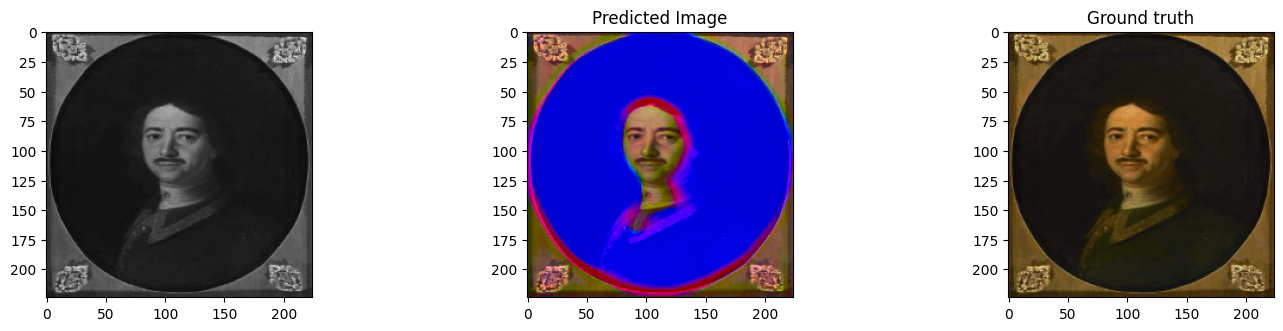

In [10]:
validation_path = "./validation_set/painting/"
show_result(validation_path + "0017.jpg")

1/1 [==============================] - 0s 82ms/step


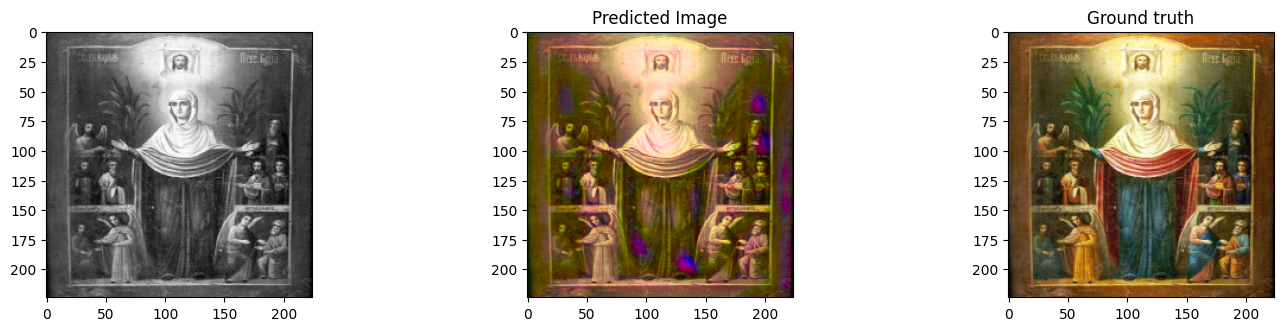

In [11]:
show_result("training_set/iconography/314.jpg")


1/1 [==============================] - 0s 85ms/step


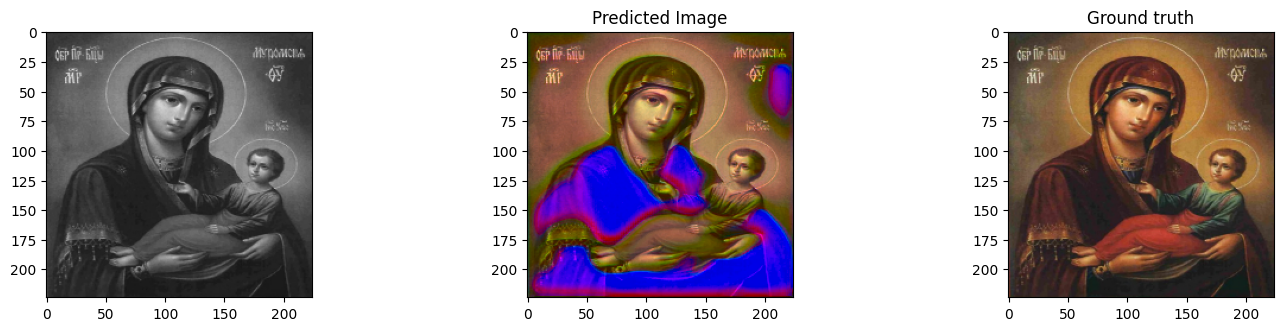

In [12]:
show_result("training_set/iconography/698.jpg")

1/1 [==============================] - 0s 86ms/step


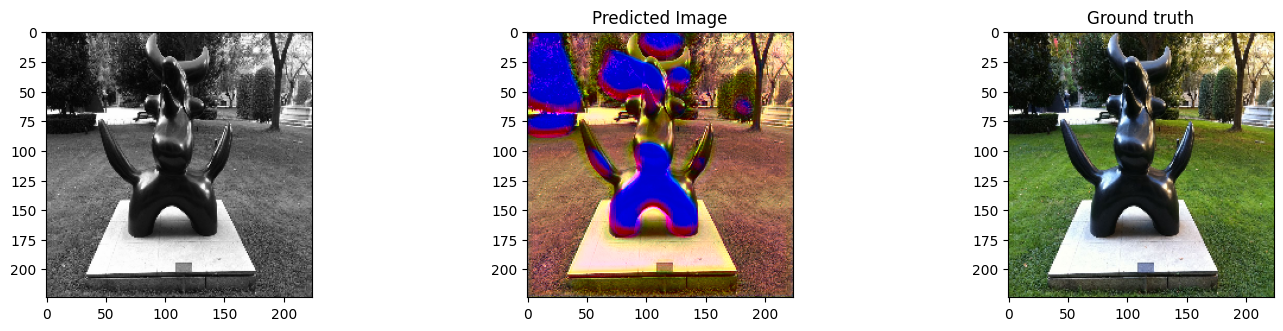

In [13]:
show_result("training_set/sculpture/240.jpg")

1/1 [==============================] - 0s 83ms/step


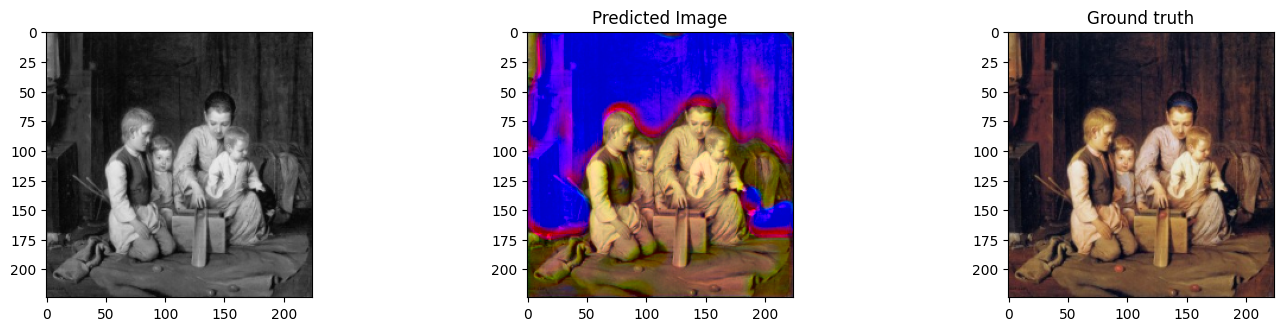

In [14]:
show_result("training_set/painting/1577.jpg")

1/1 [==============================] - 0s 86ms/step


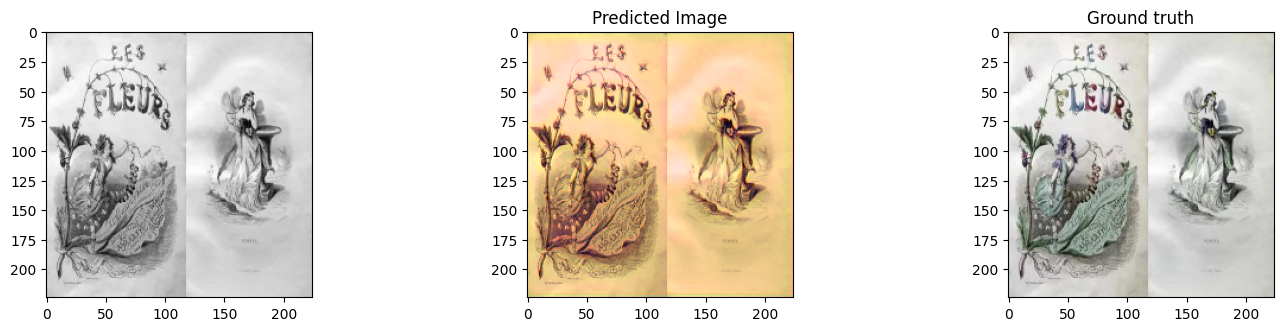

In [16]:
show_random_result("training_set/drawings")